### <p style="text-align: right;"> &#9989; Andrew Koren</p>

# PHY480 Day 9

## In-class activity: Ordinary differential equations (ODE) continued, leapfrog method

In this in-class assignment we explore how to build a numerical ODE solver specifically for physical systems, exploiting special structure that many classical and quantum systems possess.

For a Hamiltonian system with the (separable) Hamiltonian

$$
H(p,q)=T(p)+V(q),
$$

the equations of motion are

$$
\frac{dq}{dt}=\frac{\partial H}{\partial p}=\frac{\partial T}{\partial p},
$$

$$
\frac{dp}{dt}=-\frac{\partial H}{\partial q}=-\frac{\partial V}{\partial q}\equiv f(q).
$$

In most cases we deal with the kinetic energy that is quadratic in $p$ so that $\partial T/\partial p=p$. In this case the first equation is simply the relation between the rate of change of position and momentum, while the second equation contains all the dynamics of the system, given by the forces $f(q)$.

The leapfrog method propagates the momentum and velocity shifted by a half step:

$$
p(t+h/2)=p(t-h/2)+hf(q(t)),
$$

$$
q(t+h)=q(t)+hp(t+h/2).
$$

The scheme is similar to the forward Euler integrator, however, it is $O(h^2)$ of global accuracy and has better energy conservation properties, as we will see below.


In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Task 1.** Code the leapfrog integration scheme. To start the scheme make a half-step to advance the momentum. After that $q$ and $p$ are properly shifted by half a step and can be advanced in a loop, momentum first, then position. At the very last step one needs to advance the momentum by half a step again, to synchronize it with the position.


In [66]:
def leap(q, p, f, h):
    '''
    Time evolves by h

    Args:
        q: start position q(t)
        p: start momentum p(t-h/2)
        f: forces (pre-calculated)
        h: step size
    Returns: q(t+h), p(t+h/2)
    '''
    ph = p + h*f
    qh = q + h*ph
    return qh, ph



In [ ]:
# integrate Hamilton's equations dq/dt = p and dp/dt=f(q) with a leapfrog scheme
# Input:
# forces -- a function that returns f(q), as an array of the same dimension as q and p
# q0 -- the initial value of the position, it must be a NumPy array or a list
#       (even in the scalar case it must be defined as array or list with one element)
# p0 -- the initial value of the momentum, it must be a NumPy array or a list
#       (even in the scalar case it must be defined as array or list with one element)
# t0 -- initial time
# nsteps -- number of steps
# h -- step size
# *args -- additional arguments (e.g. parameters) for f(q)
# Output:
# status -- =0 on success
# q, p -- the position and momenta at the end of the trajectory q(t0+nsteps*h), p(t0+nsteps*h)
# tlist -- list of all time points during the integration
# qlist -- list of all positions during the trajectory, of size nsteps+1
# plist -- list of all momenta during the trajectory, of size nsteps+2 (!)
def integrate_ode_leapfrog( forces, q0, p0, t0, nsteps, h, *args ):
    
    # initialization
    tlist = [ t0 ]
    status = 1

    # unpack position and momentum explicitly
    q = q0.copy()
    p = p0.copy()
    
    qlist = [ q.copy() ]
    plist = [ p.copy() ]

    # first half step for momentum
    if args==None:
        f = forces( t0, q )
    else:
        f = forces( t0, q, *args )
    p += h/2*f
    plist.append( p.copy() )

    # YOUR CODE HERE
    for n in range(nsteps):
        t = t0 + n*h
        f = forces(t, qlist[-1], *args) if args else forces(t, qlist[-1])
        qh, ph = leap(qlist[-1], plist[-1], f, h)
        tlist.append(t+h)
        qlist.append(qh)
        plist.append(ph)

    # only have p(t+h/2), still need p(t) 
    pf = (plist[-1]+plist[-2])/2

    status = 0

    return status, qlist[-1], pf, tlist, qlist, plist

**Task 2.** Consider the harmonic oscillator system in one dimension that we considered before. In this case $f(q)=-\omega^2 q$. Code the `forces_ho` function that returns the right hand side of the second Hamilton's equation.

In [103]:
# force for one-dimensional harmonic oscillator
# Input:
# t -- time
# q -- position
# omega -- constant, frequency
# Output:
# f(q)
def forces_ho( t, q, omega=1.0, f0=0.0):

    return -omega**2*q+f0*np.sin(omega*t)


**Task 3.** Solve the equations of motion using the code below. If you coded the `integrate_ode_leapfrog` function properly, it returns a list of time points of size `nsteps+1` (time is propagated by full step $h$), a list of $q$ values of size `nsteps+1` ($q$ values at the beginning and at full time steps $h$ along the trajectory) and a list of $p$ values of size `nsteps+2`. The latter size is larger because that list should contain $p(0)$, $p(t_f)$ and the momenta at half-integer steps in between (i.e. the momenta are recorded at time $0$, $h/2$, $3h/2$, $\dots$, $t_f-h/2$, $t_f$). To calculate the total energy we need both $q$ and $p$ at the integer multiples of $h$. A simple solution is to approximate $p(t)\approx (p(t-h/2)+p(t+h/2))/2$. This is done by the code that produces the `p_aligned` list below.

In [104]:
# initial time
t0 = 0.

# initial conditions
q0 = np.array( [2.] )
p0 = np.array( [0.] )

# frequency
omega=2*np.pi

# final time
tf = 10.

# number of steps
nsteps=40000 # try 40, 100, 200, 400
# time step
h = tf/nsteps

# solve
status, q, p, tlist, qlist, plist = integrate_ode_leapfrog( forces_ho, q0, p0, t0, nsteps, h, omega )
assert status == 0

# align the momenta
p_aligned = [ p0.copy() ]
for i in range(1,nsteps):
    p_aligned.append( (plist[i]+plist[i+1])/2 )
p_aligned.append( plist[-1].copy() )


**Task 4.** Plot the position $q$ and momentum $p$, as we did for the integration methods that we considered earlier. Plot the trajectory in the phase space (i.e. taking $q$ as $x$ and $p$ as $y$). Plot the total energy $p^2/2+\omega^2q^2/2$ as function of time.

(0.0, 86.98913398568821)

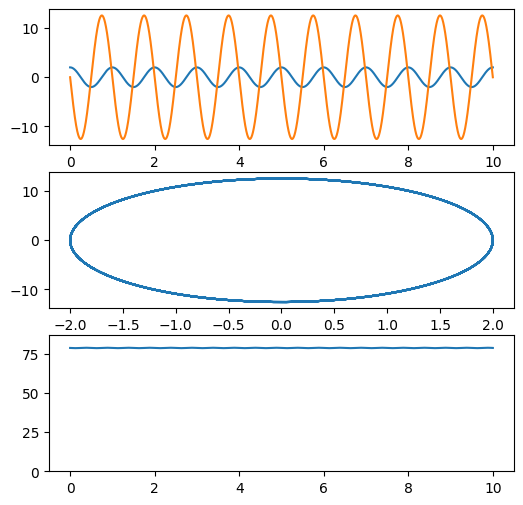

In [105]:
E = (np.array(p_aligned)**2)/2 + (omega**2*np.array(qlist)**2)/2

fig, (ax0, ax1, ax2) = plt.subplots(3,1,sharex=False)
fig.set_figwidth(6)
fig.set_figheight(6)

ax0.plot(tlist, qlist)
ax0.plot(tlist, p_aligned)
ax1.plot(qlist, p_aligned)
#ax1.set_xlim(-25, 25)
ax2.plot(tlist, E)
ax2.set_ylim(0, max(E)*1.1)

&#169; Copyright 2025,  Michigan State University Board of Trustees